# PDF knowldge base example
## Neural Search using SPLADE with OpenAI Interface

In [48]:
# pip install pinecone-client[grpc]
from pinecone import Pinecone, ServerlessSpec
from pinecone.grpc import PineconeGRPC
from openai import AzureOpenAI
from PyPDF2 import PdfReader

import torch
from sentence_transformers import SentenceTransformer
from splade.models.transformer_rep import Splade # pip install git+https://github.com/naver/splade.git
from transformers import AutoTokenizer

from tqdm.autonotebook import tqdm
import os

In [49]:
torch.cuda.is_available()

True

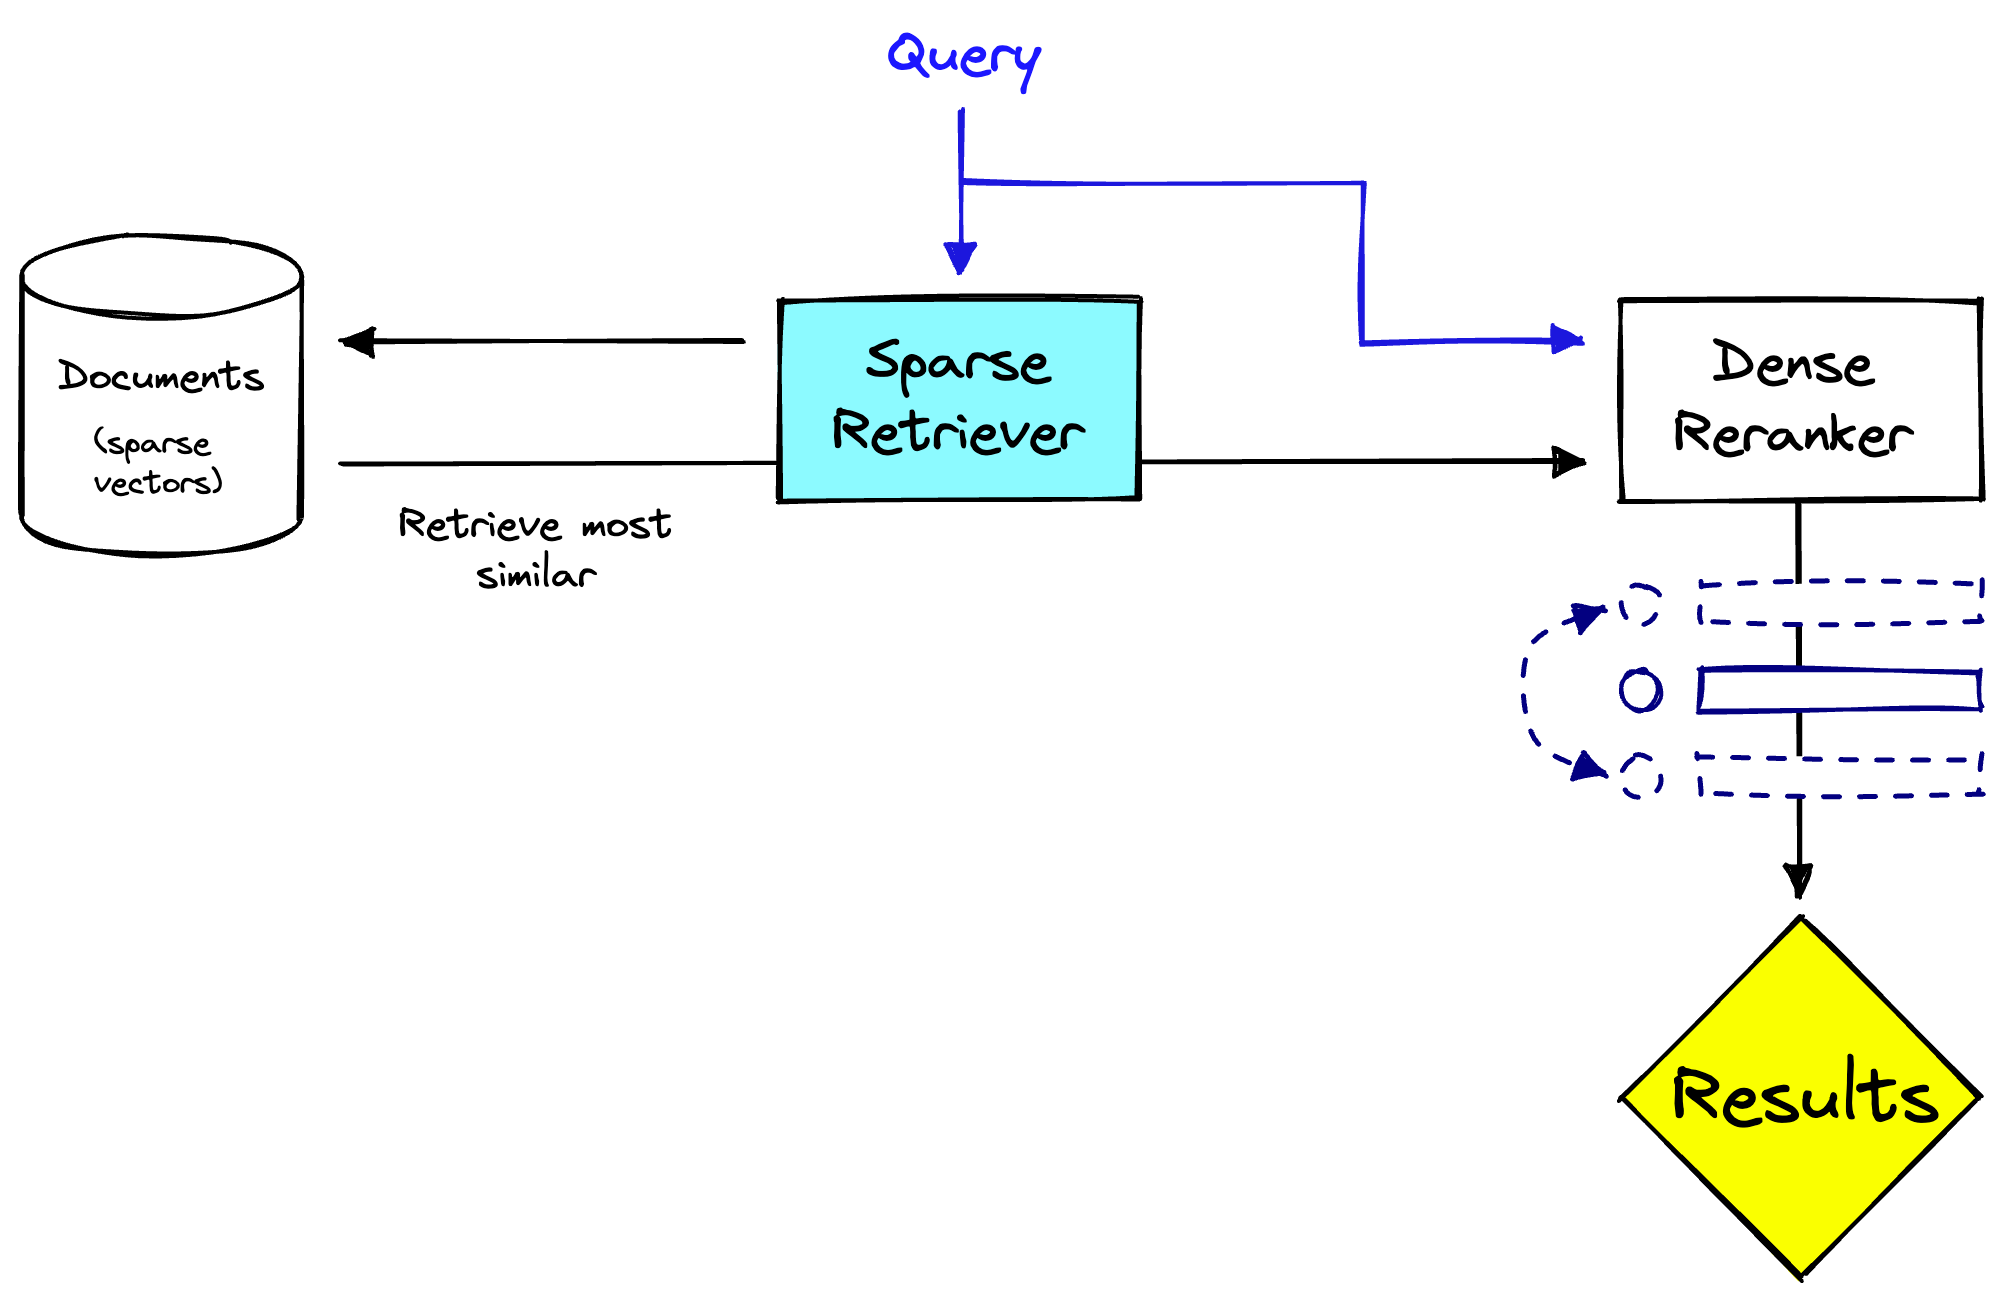

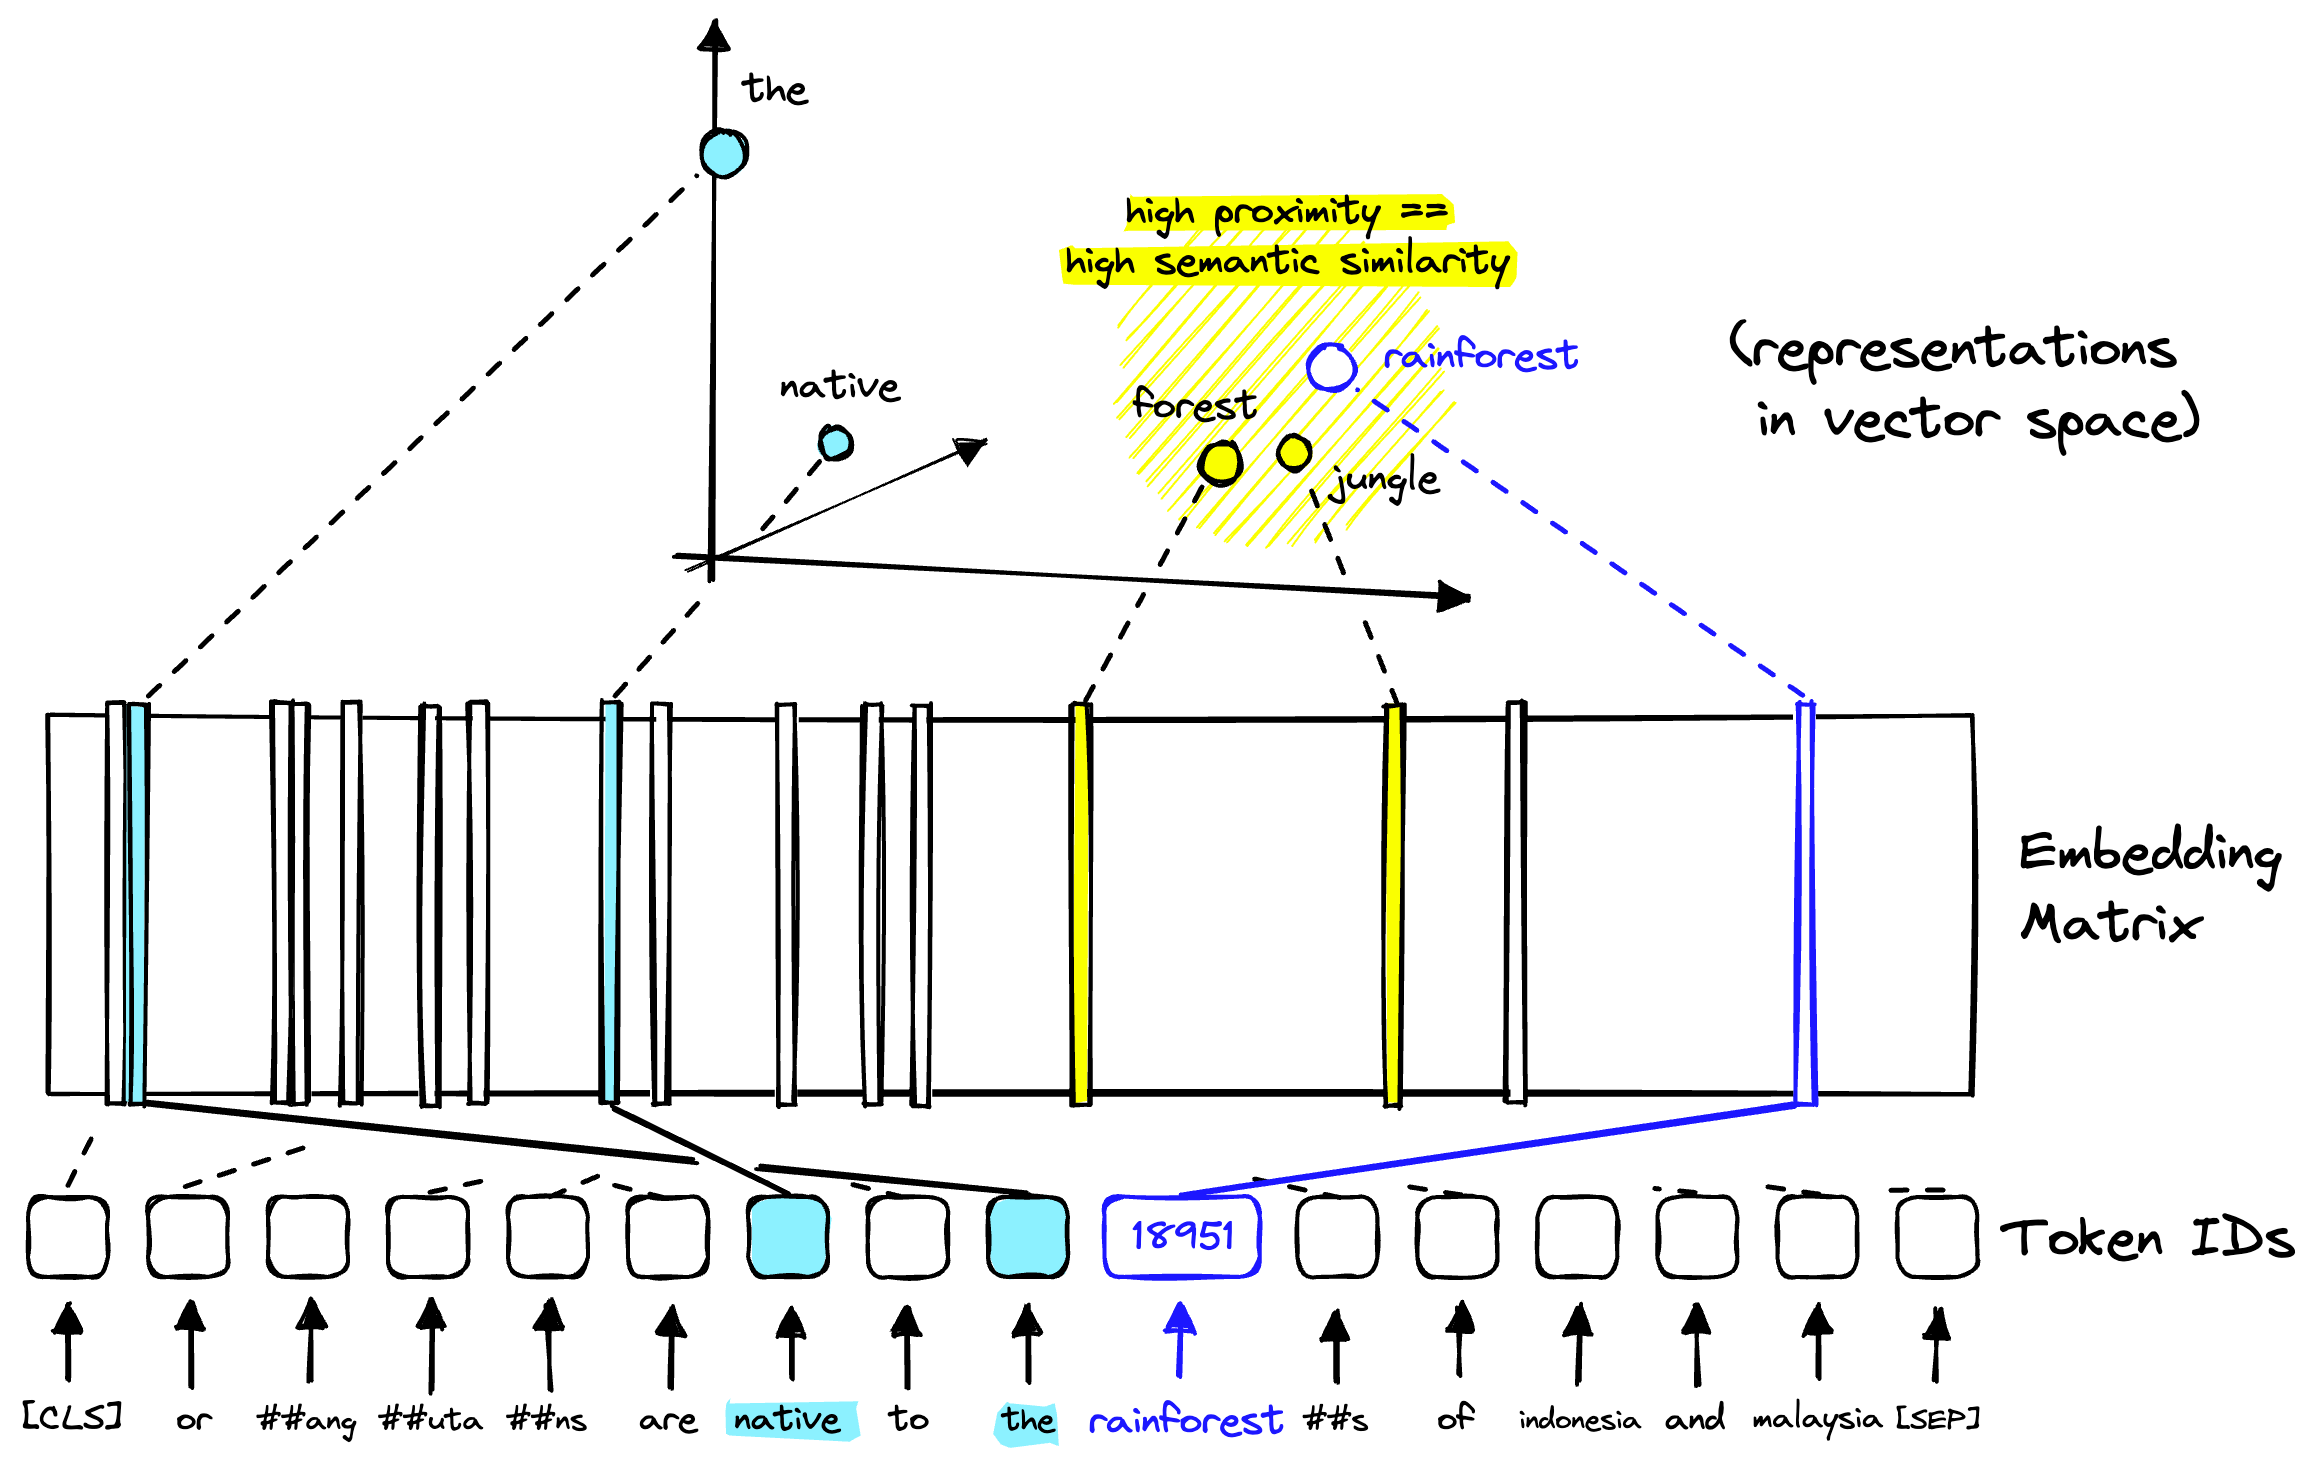

## Specify Inputs

In [61]:
index_name = 'urtec2023'
document_path="/mnt/d/repos/urtec/2023"

# we encode and insert in batches of 64
batch_size = 64

OPENAI_COMPLETION_ENGINE = 'text-davinci-003'
OPENAI_CONTEXT_LENGTH_LIMIT = 4000
EMBED_MODEL = 'multi-qa-mpnet-base-dot-v1'
EMBED_CROSS_MODEL = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
READER_MODEL = 'deepset/electra-base-squad2'

pinecone_api_key = '' # https://app.pinecone.io/projects
google_api_key = '' # https://console.cloud.google.com/apis/dashboard 

# Azure Instance
openai_api_key = ''
# your endpoint should look like the following https://YOUR_RESOURCE_NAME.openai.azure.com/
openai_api_base =  '' 
#This will correspond to the custom name you chose for your deployment when you deployed a model. 
deployment_name=''
client = AzureOpenAI(
    # https://learn.microsoft.com/en-us/azure/ai-services/openai/reference#rest-api-versioning
    api_version="2023-07-01-preview",
    azure_endpoint=openai_api_base,
    api_key=openai_api_key,
)

pinecone_environment = 'us-west-2'
index_documents = True

In [10]:
limit = 512

def chunker(contexts: list):
    chunks = []
    all_contexts = contexts.split('.')
    chunk = []
    for context in all_contexts:
        chunk.append(context)
        if len(chunk) >= 3 and len('.'.join(chunk)) > limit:
            # surpassed limit so add to chunks and reset
            chunks.append('.'.join(chunk).strip()+'.')
            # add some overlap between passages
            chunk = chunk[-2:]
    # if we finish and still have a chunk, add it
    if chunk is not None:
        chunks.append('.'.join(chunk))
    return chunks

def get_chunked_text(pdf_filename):
    reader = PdfReader(pdf_filename)
    # read data from the file and put them into a variable called raw_text
    raw_text = ''
    for i, page in enumerate(reader.pages):
        text = page.extract_text()
        if text:
            raw_text += text
    texts = chunker(raw_text)
    return texts

In [11]:
# init connection to pinecone
pc = PineconeGRPC(pinecone_api_key)

In [53]:
def openai_complete(context, prompt, max_answer_len=256) -> str:
        text_context = (context[:OPENAI_CONTEXT_LENGTH_LIMIT] + '...') \
            if len(context) > OPENAI_CONTEXT_LENGTH_LIMIT else context

        openai_prompt = f"{text_context}\n\n{prompt}"
        messages=[
            {
                "role": "user",
                "content": openai_prompt,
            },
        ]

        response =  client.chat.completions.create(
            model=OPENAI_COMPLETION_ENGINE,
            messages=messages,
            temperature=0.7,
            max_tokens=max_answer_len,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        return response.choices[0].message.content.strip()

def openai_summary(text, max_answer_len=255) -> str:
        if len(text) < max_answer_len:
            return text
        return openai_complete(text, "TLDR:", max_answer_len)[0]
    
def openai_question(question, context, max_answer_len=512) -> str:
        context = context[0:9000]
        openai_prompt = f"Answer the question: {question}\n\nContext: {context}\n\nAnswer:"
        messages=[
            {
                "role": "user",
                "content": openai_prompt,
            },
        ]

        response =  client.chat.completions.create(
            model=OPENAI_COMPLETION_ENGINE,
            messages=messages,
            temperature=0.7,
            max_tokens=max_answer_len,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        return response.choices[0].message.content.strip()

In [13]:
def get_files_recursive(dir_path):
    files = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        files.extend(filenames)
        for dirname in dirnames:
            dir = os.path.join(dirpath, dirname)
            files.extend(get_files_recursive(dir))
    return files

In [14]:
def read_file_data(document_path, PDF_filenames):
    file_data=[]
    text=[]
    for pdf_filename in PDF_filenames:
        text = get_chunked_text(document_path+"/"+pdf_filename)
        for i, context in enumerate(text):
            file_data.append({
                'id': f"{pdf_filename}-{i}",
                'context': context
            })
    return file_data

In [15]:
if index_documents:
    PDF_filenames = get_files_recursive(document_path)
    file_data = read_file_data(document_path, PDF_filenames)
    file_data

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# check device being run on
if device != 'cuda':
    print("==========\n"+
          "WARNING: You are not running on GPU so this may be slow.\n"+
          "If on Google Colab, go to top menu > Runtime > Change "+
          "runtime type > Hardware accelerator > 'GPU' and rerun "+
          "the notebook.\n==========")

dense_model = SentenceTransformer(
    'msmarco-bert-base-dot-v5',
    device=device
)
dense_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [17]:
if index_documents:
    # create embedding
    emb = dense_model.encode(file_data[0]['context'])
    emb.shape

    # The model returns 768 dimensional dense vectors, this is also reflected in the model attributes.
    dim = dense_model.get_sentence_embedding_dimension()
    dim 

In [22]:
index_names = [index['name'] for index in pc.list_indexes()]

In [26]:
if index_documents:
    if index_name not in index_names:
        pc.create_index(
            name=index_name,
            dimension=dim, # Replace with your model dimensions
            metric="dotproduct", # Replace with your model metric
            spec=ServerlessSpec(
                cloud="aws",
                region=pinecone_environment
            ) 
        )

index = pc.Index(index_name)
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 0}},
 'total_vector_count': 0}

In [27]:
sparse_model_id = 'naver/splade-cocondenser-ensembledistil'

sparse_model = Splade(sparse_model_id, agg='max')
sparse_model.to(device)  # move to GPU if possible
sparse_model.eval()

In [28]:
# The model takes tokenized inputs that are built using a tokenizer initialized with the same model ID.
tokenizer = AutoTokenizer.from_pretrained(sparse_model_id)

if index_documents:
    tokens = tokenizer(file_data[0]['context'], return_tensors='pt')

In [29]:
if index_documents:
    # to create sparse vectors
    with torch.no_grad():
        sparse_emb = sparse_model(
            d_kwargs=tokens.to(device)
        )['d_rep'].squeeze()
    sparse_emb.shape

In [30]:
if index_documents:
    sparse_emb

In [31]:
if index_documents:
    indices = sparse_emb.nonzero().squeeze().cpu().tolist()
    print(len(indices))

159


In [32]:
if index_documents:
    # We have 174 non-zero values, we use them to create a dictionary of index positions to scores
    values = sparse_emb[indices].cpu().tolist()
    sparse = {'indices': indices, 'values': values}
    sparse

In [33]:
if index_documents:
    idx2token = {idx: token for token, idx in tokenizer.get_vocab().items()}

In [34]:
if index_documents:
    sparse_dict_tokens = {
        idx2token[idx]: round(weight, 2) for idx, weight in zip(indices, values)
    }
    # sort so we can see most relevant tokens first
    sparse_dict_tokens = {
        k: v for k, v in sorted(
            sparse_dict_tokens.items(),
            key=lambda item: item[1],
            reverse=True
        )
    }
    sparse_dict_tokens

In [35]:
def builder(records: list):
    ids = [x['id'] for x in records]
    contexts = [x['context'] for x in records]
    # create dense vecs
    dense_vecs = dense_model.encode(contexts).tolist()
    # create sparse vecs
    input_ids = tokenizer(
        contexts, return_tensors='pt',
        padding=True, truncation=True
    )
    with torch.no_grad():
        sparse_vecs = sparse_model(
            d_kwargs=input_ids.to(device)
        )['d_rep'].squeeze()
    # convert to upsert format
    upserts = []
    for _id, dense_vec, sparse_vec, context in zip(ids, dense_vecs, sparse_vecs, contexts):
        # extract columns where there are non-zero weights
        indices = sparse_vec.nonzero().squeeze().cpu().tolist()  # positions
        values = sparse_vec[indices].cpu().tolist()  # weights/scores
        # build sparse values dictionary
        sparse_values = {
            "indices": indices,
            "values": values
        }
        # build metadata struct
        metadata = {'context': context}
        # append all to upserts list as pinecone.Vector (or GRPCVector)
        upserts.append({
            'id': _id,
            'values': dense_vec,
            'sparse_values': sparse_values,
            'metadata': metadata
        })
    return upserts

In [36]:
if index_documents:
    builder(file_data[:3])

In [37]:
if index_documents:
    batch_size = 64
    
    for i in tqdm(range(0, len(file_data), batch_size)):
        # extract batch of data
        i_end = min(i+batch_size, len(file_data))
        batch = file_data[i:i_end]
        # pass data to builder and upsert
        index.upsert(builder(file_data[i:i+batch_size]))

  0%|          | 0/412 [00:00<?, ?it/s]

In [38]:
if index_documents:
    len(file_data), index.describe_index_stats()

In [39]:
def encode(text: str):
    # create dense vec
    dense_vec = dense_model.encode(text).tolist()
    # create sparse vec
    input_ids = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        sparse_vec = sparse_model(
            d_kwargs=input_ids.to(device)
        )['d_rep'].squeeze()
    # convert to dictionary format
    indices = sparse_vec.nonzero().squeeze().cpu().tolist()
    values = sparse_vec[indices].cpu().tolist()
    sparse_dict = {"indices": indices, "values": values}
    # return vecs
    return dense_vec, sparse_dict

In [40]:
query = "How do I identify and address frac driven interference events?"
dense, sparse = encode(query)
# query
xc = index.query(
    vector=dense,
    sparse_vector=sparse,
    top_k=5,  # how many results to return
    include_metadata=True
)
xc

{'matches': [{'id': '3854683.pdf-34',
              'metadata': {'context': 'However, a production interference '
                                      'event attributed to offset well fracs '
                                      'can lead to significant changes in the '
                                      'well productivity decline trend. The '
                                      'first step in the MS-PIBF method is to '
                                      'automatically detect any breakpoints in '
                                      'PI decline against cumulative fluid '
                                      'produced and identify it as a segment. '
                                      '2. Segment verification – Next, it is '
                                      'essential to verify if the PI '
                                      'segmentation is an outcome of a '
                                      'frac-hit event or an offset well '
                                  

In [41]:
def hybrid_scale(dense, sparse, alpha: float):
    # check alpha value is in range
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

In [42]:
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1.0)
# query
xc = index.query(
    vector=hdense,
    sparse_vector=hsparse,
    top_k=5,  # how many results to return
    include_metadata=True
)
xc

{'matches': [{'id': '3854683.pdf-34',
              'metadata': {'context': 'However, a production interference '
                                      'event attributed to offset well fracs '
                                      'can lead to significant changes in the '
                                      'well productivity decline trend. The '
                                      'first step in the MS-PIBF method is to '
                                      'automatically detect any breakpoints in '
                                      'PI decline against cumulative fluid '
                                      'produced and identify it as a segment. '
                                      '2. Segment verification – Next, it is '
                                      'essential to verify if the PI '
                                      'segmentation is an outcome of a '
                                      'frac-hit event or an offset well '
                                  

In [43]:
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.0)
# query
xc = index.query(
    vector=hdense,
    sparse_vector=hsparse,
    top_k=5,  # how many results to return
    include_metadata=True
)
xc

{'matches': [{'id': '3854683.pdf-34',
              'metadata': {'context': 'However, a production interference '
                                      'event attributed to offset well fracs '
                                      'can lead to significant changes in the '
                                      'well productivity decline trend. The '
                                      'first step in the MS-PIBF method is to '
                                      'automatically detect any breakpoints in '
                                      'PI decline against cumulative fluid '
                                      'produced and identify it as a segment. '
                                      '2. Segment verification – Next, it is '
                                      'essential to verify if the PI '
                                      'segmentation is an outcome of a '
                                      'frac-hit event or an offset well '
                                  

In [44]:
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.2)
# query
xc = index.query(
    vector=hdense,
    sparse_vector=hsparse,
    top_k=5,  # how many results to return
    include_metadata=True
)
xc

{'matches': [{'id': '3854683.pdf-34',
              'metadata': {'context': 'However, a production interference '
                                      'event attributed to offset well fracs '
                                      'can lead to significant changes in the '
                                      'well productivity decline trend. The '
                                      'first step in the MS-PIBF method is to '
                                      'automatically detect any breakpoints in '
                                      'PI decline against cumulative fluid '
                                      'produced and identify it as a segment. '
                                      '2. Segment verification – Next, it is '
                                      'essential to verify if the PI '
                                      'segmentation is an outcome of a '
                                      'frac-hit event or an offset well '
                                  

In [72]:
def answer_neural_search_question_GPT(question, results):
    context = ""
    for result in results['matches']:
        context += (result['metadata']['context']) + " "
        
    prompt = "Answer the question: "+question+" using the following context.\n\nContext:\n"+context+"\n\nAnswer:"
    messages=[{
                "role": "user",
                "content": prompt,
    }]

    response =  client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            temperature=0.1,
            max_tokens=1000
        )
    result = response.choices[0].message.content.strip()
    return result, prompt

def answer_neural_search_question_GPT_chat(question, prev_session, results):
    context = ""
    for result in results['matches']:
        context += (result['metadata']['context']) + " "
        
    prompt = "Answer a new question: "+question+" using the following context: "+context+" and previous chat history: "+prev_session+"\n\nAnswer:"
    messages=[{
                "role": "user",
                "content": prompt,
    }]
    response =  client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            temperature=0.7,
            max_tokens=1000
        )
    result = response.choices[0].message.content.strip()
    return result, prompt

def get_summary_from_session_GPT(text):
    prompt = text+"\n\nChat session summary:"
    messages=[{
                "role": "user",
                "content": prompt,
    }]
    response =  client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            temperature=0.1,
            max_tokens=3000
        )
    result = response.choices[0].message.content.strip()
    return result


def answer_neural_search_code_question_GPT_chat(question, prev_session, results):
    context = ""
    for result in results['matches']:
        context += (result['metadata']['context']) + " "
        
    prompt = "Write python code for the task: "+question+" using the following context from this chat session.\n\nPrevious chat:"+prev_session+"\n\nContext:"+context+"\n\nPython code:"
    messages=[{
                "role": "user",
                "content": prompt,
    }]
    response =  client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            temperature=0.7,
            max_tokens=1000
        )
    result = response.choices[0].message.content.strip()
    return result, prompt

def neural_search_summary_GPT_chat(question, prev_session):
    prompt = "Summarize this chat session.\n\nPrevious chat:"+prev_session+"\n\nSummary:"
    messages=[{
                "role": "user",
                "content": prompt,
    }]    
    response =  client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            temperature=0.7,
            max_tokens=1000
        )
    result = response.choices[0].message.content.strip()
    return result, prompt

In [62]:
query = "How do I identify and address frac driven interference events?"
dense, sparse = encode(query)
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)  # 30% weighted dense and sparse matrix
# query
xc = index.query(
    vector=hdense,
    sparse_vector=hsparse,
    top_k=5,  # how many results to return
    include_metadata=True
)
xc

{'matches': [{'id': '3854683.pdf-34',
              'metadata': {'context': 'However, a production interference '
                                      'event attributed to offset well fracs '
                                      'can lead to significant changes in the '
                                      'well productivity decline trend. The '
                                      'first step in the MS-PIBF method is to '
                                      'automatically detect any breakpoints in '
                                      'PI decline against cumulative fluid '
                                      'produced and identify it as a segment. '
                                      '2. Segment verification – Next, it is '
                                      'essential to verify if the PI '
                                      'segmentation is an outcome of a '
                                      'frac-hit event or an offset well '
                                  

In [73]:
answer, prompt = answer_neural_search_question_GPT(query, xc)
print(answer)

To identify and address frac driven interference events, it is essential to first detect any breakpoints in PI decline against cumulative fluid produced and identify it as a segment. The next step is to verify if the PI segmentation is an outcome of a frac-hit event or an offset well production interference. This can be done using a data-driven approach that honors the physics of reservoir behavior during transient well-flow, which is represented by a material balance on a closed boundary with expanding control volume, combined with the calculated dynamic drainage volume (𝐷𝐷𝑉) to calculate the average reservoir pressures (𝑃𝑎𝑣𝑔) and well productivity index (𝑃𝐼) profiles as a function of time. This approach can help detect well interference events and quantify their resulting impact on future well production. Remediation treatments can then be applied to address the adverse effects of frac hits, such as damaging production tubing, casing, wellheads, or affecting the productivity of the i

In [74]:
prev_prompt = query+" "+answer
prev_prompt

'How do I identify and address frac driven interference events? To identify and address frac driven interference events, it is essential to first detect any breakpoints in PI decline against cumulative fluid produced and identify it as a segment. The next step is to verify if the PI segmentation is an outcome of a frac-hit event or an offset well production interference. This can be done using a data-driven approach that honors the physics of reservoir behavior during transient well-flow, which is represented by a material balance on a closed boundary with expanding control volume, combined with the calculated dynamic drainage volume (𝐷𝐷𝑉) to calculate the average reservoir pressures (𝑃𝑎𝑣𝑔) and well productivity index (𝑃𝐼) profiles as a function of time. This approach can help detect well interference events and quantify their resulting impact on future well production. Remediation treatments can then be applied to address the adverse effects of frac hits, such as damaging production t

In [75]:
chat_summary = get_summary_from_session_GPT(prev_prompt)
chat_summary

'Customer: How do I identify and address frac driven interference events?\n\nAI: To identify and address frac driven interference events, it is essential to first detect any breakpoints in PI decline against cumulative fluid produced and identify it as a segment. The next step is to verify if the PI segmentation is an outcome of a frac-hit event or an offset well production interference. This can be done using a data-driven approach that honors the physics of reservoir behavior during transient well-flow, which is represented by a material balance on a closed boundary with expanding control volume, combined with the calculated dynamic drainage volume (𝐷𝐷𝑉) to calculate the average reservoir pressures (𝑃𝑎𝑣𝑔) and well productivity index (𝑃𝐼) profiles as a function of time. This approach can help detect well interference events and quantify their resulting impact on future well production. Remediation treatments can then be applied to address the adverse effects of frac hits, such as dama

In [76]:
query = "Are there other causes that could increase risk of the frac driven inteference?"
chat_summary = get_summary_from_session_GPT(prompt)

dense, sparse = encode(query)
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)  # 50% weighted dense and sparse matrix
# query
xc = index.query(
    vector=hdense,
    sparse_vector=hsparse,
    top_k=5,  # how many results to return
    include_metadata=True
)

answer, prompt = answer_neural_search_question_GPT_chat(query, chat_summary, xc)
answer

'Yes, there are several other causes that could increase the risk of frac driven interference, such as parent-child spacing, completion design, parent well depletion, and drilling schedules optimization decisions. Additionally, infill-to-parent well frac hits or fracture driven interactions can occur when infill well fractures intersect with parent well depleted fractures or parent wellbores themselves, negatively impacting both parent and infill well production.'

In [77]:
query = "Are there any actions than can mitigate the risk of frac driven interference?"
chat_summary = get_summary_from_session_GPT(prompt)

dense, sparse = encode(query)
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)  # 50% weighted dense and sparse matrix
# query
xc = index.query(
    vector=hdense,
    sparse_vector=hsparse,
    top_k=5,  # how many results to return
    include_metadata=True
)

answer, prompt = answer_neural_search_question_GPT_chat(query, chat_summary, xc)
answer

'Yes, alternative stimulation strategies, such as repressurization of the parent well, are being studied to mitigate the appearance of frac driven interference. Modeling and simulation of interacting wells is also being used to evaluate potential mechanisms for the appearance of frac hits and their mitigation.'

In [78]:
query = "Summarize our conversation"
chat_summary = get_summary_from_session_GPT(prompt)
answer, prompt = neural_search_summary_GPT_chat(query, chat_summary)
answer

'There are alternative methods being researched to mitigate the appearance of frac hits while maintaining optimal drainage of the reservoir. Repressurization of the parent well is one such method. Modeling and simulation of interacting wells is also a useful tool for evaluating potential mechanisms for frac hits and their mitigation.'